# 김형준 박사님 논문 네트워크 구현
- A novel deep learning-based forecasting model optimized by heuristic algorithm for energy management of microgrid, Applied Energy, 332 (2023)

## LSTM+GAM 구조
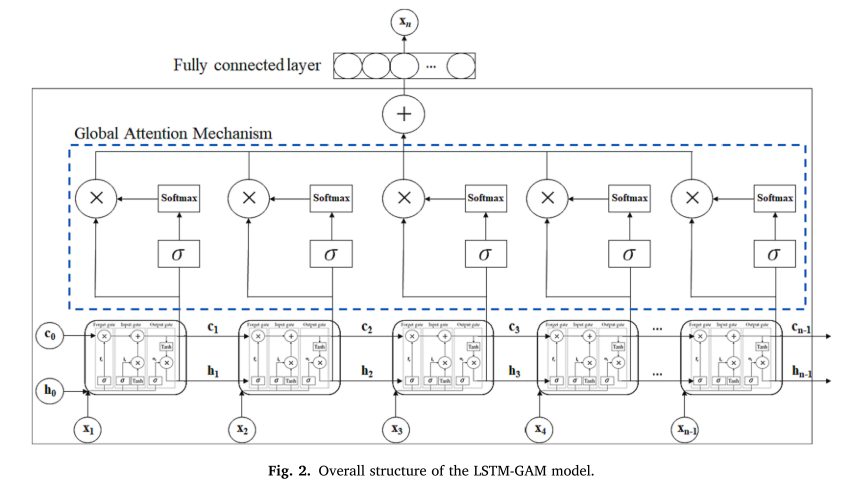
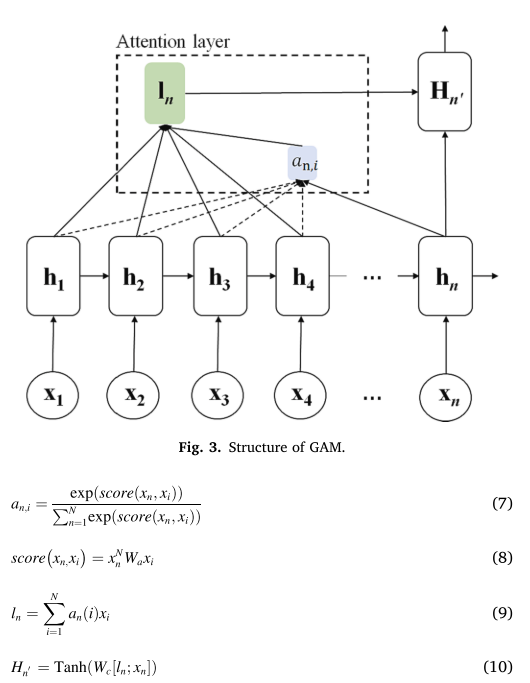

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# LSTM 네트워크 정의
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size  # 은닉 상태의 크기 설정
        self.num_layers = num_layers  # LSTM 레이어의 수 설정
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # LSTM 레이어 정의
        self.fc = nn.Linear(hidden_size, 1)  # 최종 출력으로 가는 전결합층 정의

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # 초기 은닉 상태 설정
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # 초기 셀 상태 설정
        out, _ = self.lstm(x, (h_0, c_0))  # LSTM 레이어를 통과시킴
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력을 전결합층에 통과시킴
        return out  # 최종 출력 반환

# 글로벌 어텐션 메커니즘 정의
class GlobalAttention(nn.Module):
    def __init__(self, hidden_size):
        super(GlobalAttention, self).__init__()
        self.wa = nn.Linear(hidden_size, hidden_size, bias=False)  # 어텐션 가중치 Wa 정의
        self.wc = nn.Linear(hidden_size * 2, hidden_size, bias=False)  # 컨텍스트 벡터와 은닉 상태를 결합하는 가중치 Wc 정의

    def forward(self, hn, h):
        # 수식 (8): score(xn, xi) = xn Wa xi
        # hn: (batch_size, 1, hidden_size)
        # h: (batch_size, seq_len, hidden_size)
        # self.wa(h): (batch_size, seq_len, hidden_size)
        # self.wa(h).transpose(1, 2): (batch_size, hidden_size, seq_len)
        # hn.transpose(1, 2): (batch_size, hidden_size, 1)
        scores = torch.bmm(hn, self.wa(h).transpose(1, 2)).squeeze(1)  # 각 타임스텝의 점수 계산
        
        # 수식 (7): an,i = exp(score(xn, xi)) / sum(exp(score(xn, xi)))
        attn_weights = torch.softmax(scores, dim=1).unsqueeze(2)  # 소프트맥스를 통해 어텐션 가중치 계산
        
        # 수식 (9): ln = sum(an(i)xi)
        # attn_weights: (batch_size, seq_len, 1)
        # h: (batch_size, seq_len, hidden_size)
        attn_weights = attn_weights.repeat(1, 1, h.size(2))  # attn_weights를 h와 동일한 크기로 반복
        context = torch.sum(attn_weights * h, dim=1)  # 가중합 계산
        
        # 수식 (10): Hn' = Tanh(Wc[ln; xn])
        # context: (batch_size, hidden_size)
        # hn.squeeze(1): (batch_size, hidden_size)
        hn_prime = torch.tanh(self.wc(torch.cat((context, hn.squeeze(1)), dim=1)))  # 최종 컨텍스트 벡터 계산
        return hn_prime  # 최종 컨텍스트 벡터 반환

# LSTM과 글로벌 어텐션 메커니즘을 결합한 네트워크 정의
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMWithAttention, self).__init__()
        self.lstm_layer = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)  # LSTM 레이어 정의
        self.attention = GlobalAttention(hidden_size)  # 글로벌 어텐션 레이어 정의
        self.fc = nn.Linear(hidden_size, output_size)  # 최종 출력으로 가는 전결합층 정의

    def forward(self, x):
        h_0 = torch.zeros(self.lstm_layer.num_layers, x.size(0), self.lstm_layer.hidden_size).to(x.device)  # 초기 은닉 상태 설정
        c_0 = torch.zeros(self.lstm_layer.num_layers, x.size(0), self.lstm_layer.hidden_size).to(x.device)  # 초기 셀 상태 설정
        h, _ = self.lstm_layer(x, (h_0, c_0))  # LSTM 레이어를 통과시킴
        hn = h[:, -1, :].unsqueeze(1)  # 마지막 타임스텝의 은닉 상태를 선택
        hn_prime = self.attention(hn, h)  # 어텐션 메커니즘 적용
        output = self.fc(hn_prime)  # 최종 출력을 전결합층에 통과시킴
        return output  # 최종 출력 반환

In [3]:
# 하이퍼파라미터 설정
input_size = 10
hidden_size = 50
output_size = 1
num_layers = 1
learning_rate = 0.001
num_epochs = 100

# 데이터 생성
x_train = torch.randn(64, 100, input_size)  # 64개 샘플로 학습 데이터 생성, (batch_size, seq_len, input_size(=feature size))
y_train = torch.randn(64, output_size)
x_val = torch.randn(16, 100, input_size)  # 16개 샘플로 검증 데이터 생성
y_val = torch.randn(16, output_size)
x_test = torch.randn(16, 100, input_size)  # 16개 샘플로 테스트 데이터 생성
y_test = torch.randn(16, output_size)


# 모델 초기화
model_lstm = LSTM(input_size, hidden_size, num_layers)
model_attention = LSTMWithAttention(input_size, hidden_size, output_size, num_layers)

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=learning_rate)
optimizer_attention = optim.Adam(model_attention.parameters(), lr=learning_rate)


In [4]:
# 학습 함수
def train_model(model, optimizer, x_train, y_train, x_val, y_val, num_epochs):
    model.train()
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # Validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(x_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())
        model.train()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
    
    return train_losses, val_losses

In [ ]:
# 모델 학습
train_losses_lstm, val_losses_lstm = train_model(model_lstm, optimizer_lstm, x_train, y_train, x_val, y_val, num_epochs)
train_losses_attention, val_losses_attention = train_model(model_attention, optimizer_attention, x_train, y_train, x_val, y_val, num_epochs)

# 테스트 손실 계산
def test_model(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        test_outputs = model(x_test)
        test_loss = criterion(test_outputs, y_test)
    return test_loss.item()

test_loss_lstm = test_model(model_lstm, x_test, y_test)
test_loss_attention = test_model(model_attention, x_test, y_test)

print(f'Test Loss for LSTM: {test_loss_lstm:.4f}')
print(f'Test Loss for LSTM with Attention: {test_loss_attention:.4f}')

# 학습 및 검증 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses_lstm, label='LSTM Train Loss')
plt.plot(val_losses_lstm, label='LSTM Val Loss')
plt.plot(train_losses_attention, label='LSTM with Attention Train Loss')
plt.plot(val_losses_attention, label='LSTM with Attention Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.show()

# GA-AWPSO 
* Genetic Algorithm-Adaptive Weight Particle Swarm Optimization
* GA와 PSO의 장점을 결합하여 최적의 하이퍼파라미터를 도출
* GA는 교차(crossover)와 돌연변이(mutation)를 통해 다양성을 유지하며 최적화의 글로벌 탐색 수행
* PSO는 입자군집최적화 기법을 사용하여 로컬탐색 수행
* 수식 (11),(12): 교차(crossover) 수식
* 수식 (13): PSO의 관성가중치 업데이트
* 수식 (14): PSO의 개인인자 업데이트
* 수식 (15): PSO의 사회적 인자 업데이트 
* 수식 (16),(17): PSO 속도 업데이트
* 수식 (18): 초기 입자 설정
* 수식 (19): 적합도 함수 정의
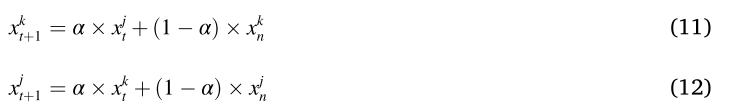
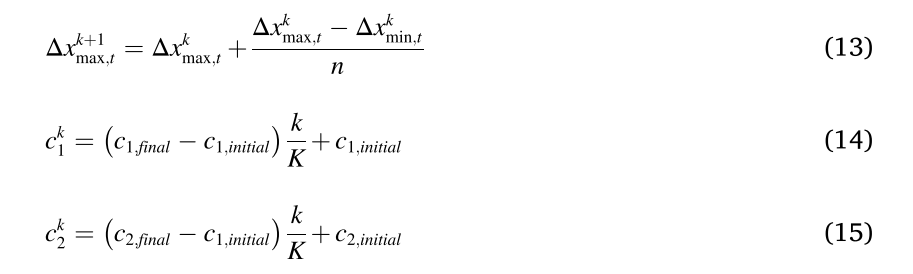
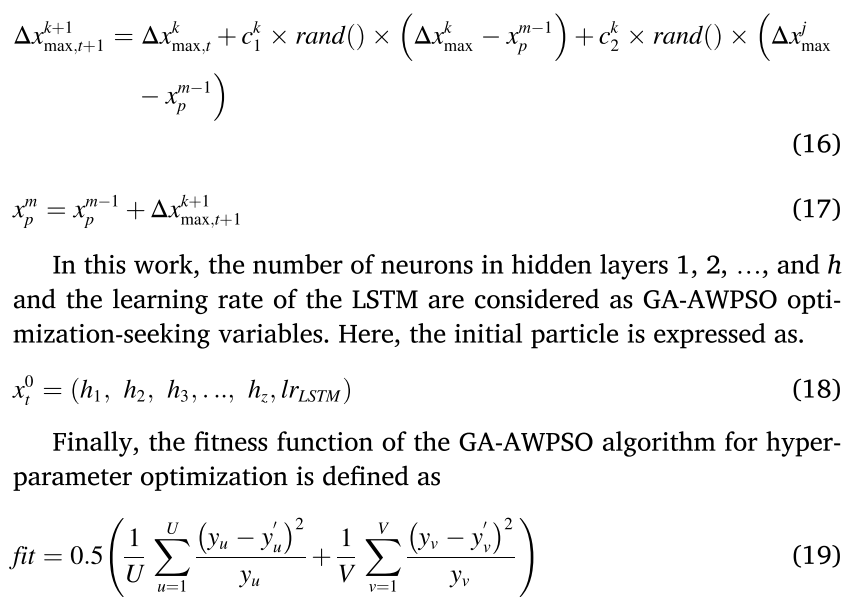

## Step
* Step3: GA-AWPSO 최적화 알고리즘 파라미터 설정, 최적화할 LSTM-GAM 하이퍼파라미터 범위 셜정
* Step4: LSTM-GAM 예측모델 구성, 각 입자의 적합도를 수식 (19)에 따라 설정
* Step5: LSTM-GAM 학습하고, 각 입자의 적합도 계산, 적합도 크기정렬하고, 각 입자를 로컬 최적 입자로 사용
* Step6: 입자 업데이트 (속도 및 위치), 생성된 인구 인코딩, 선택,교차,돌연변이 과정 적용
* Step7: 입자 적합도를 다시 계산하고, 적합도 크기 정렬, 로컬 최적입자 표시(현재 입자에서 최적적합도), 글로벌 최적 입자 표시(전체인구에서 최소 적합도)
* Step8: P_p,best, G_p,best 및 G_g,best값 비교하여, 로컬 및 글로벌 최적값 선택
* Step9: 알고리즘 종료조건 충족할 때까지 입자 속오와 위치를 업데이트, 최대 반복 횟수에 도달하면 하이퍼 파라미터 반환

In [8]:
# GA-AWPSO 파라미터 설정 (Step 3)
num_particles = 5  # 입자 수
num_iterations = 100  # PSO 반복 수 (Step 6)
num_generations = 50  # GA 세대 수 (Step 5)
c1 = 1.5  # PSO의 개인 인자 (수식 17)
c2 = 1.5  # PSO의 사회적 인자 (수식 17)
w = 0.5  # PSO의 관성 인자 (수식 16)
mutation_rate = 0.1  # 돌연변이 확률 (Step 6)
crossover_rate = 0.4  # 교차 확률 (Step 6)

# 하이퍼파라미터 범위 설정 (Step 3)
learning_rate_range = [0.0001, 0.01]  # 학습률 범위
hidden_size_range = [10, 100]  # 은닉 상태 크기 범위


# 하이퍼파라미터 초기화 (Step 3)
def initialize_particles():
    particles = []
    for _ in range(num_particles):
        learning_rate = random.uniform(*learning_rate_range)
        hidden_size = random.randint(*hidden_size_range)
        particle = {
            'learning_rate': learning_rate,  # 초기 학습률 설정 (Step 3)
            'hidden_size': hidden_size,  # 초기 은닉 상태 크기 설정 (Step 3)
            'velocity_lr': 0.0,  # 초기 학습률 속도 설정 (Step 3)
            'velocity_hs': 0.0,  # 초기 은닉 상태 속도 설정 (Step 3)
            'best_position': {'learning_rate': learning_rate, 'hidden_size': hidden_size},  # 최적 위치 초기화 (Step 3)
            'best_fitness': float('inf')  # 최적 적합도 초기화 (Step 3)
        }
        particles.append(particle)
    return particles


# 하이퍼파라미터 적합도 함수 (Step 4)
def fitness_function(particle, x_train, y_train, x_val, y_val, num_epochs):
    model = LSTM(input_size, particle['hidden_size'], num_layers)  # 모델 초기화
    optimizer = optim.Adam(model.parameters(), lr=particle['learning_rate'])  # 옵티마이저 초기화
    _, val_losses = train_model(model, optimizer, x_train, y_train, x_val, y_val, num_epochs)  # 모델 학습 및 검증
    return 0.5 * val_losses[-1]  # 적합도 함수 (수식 19 적용)

# PSO 속도 및 위치 업데이트 (Step 6)
def update_velocity(particle, global_best_position):
    r1, r2 = random.random(), random.random()  # 무작위 값 생성 (Step 6)
    particle['velocity_lr'] = (w * particle['velocity_lr'] + 
                               c1 * r1 * (particle['best_position']['learning_rate'] - particle['learning_rate']) + 
                               c2 * r2 * (global_best_position['learning_rate'] - particle['learning_rate']))  # 학습률 속도 업데이트 (수식 17)
    particle['velocity_hs'] = (w * particle['velocity_hs'] + 
                               c1 * r1 * (particle['best_position']['hidden_size'] - particle['hidden_size']) + 
                               c2 * r2 * (global_best_position['hidden_size'] - particle['hidden_size']))  # 은닉 상태 속도 업데이트 (수식 17)

def update_position(particle):
    particle['learning_rate'] += particle['velocity_lr']  # 학습률 위치 업데이트 (Step 6)
    particle['learning_rate'] = np.clip(particle['learning_rate'], *learning_rate_range)  # 학습률 범위 내로 클리핑 (Step 6)
    particle['hidden_size'] += particle['velocity_hs']  # 은닉 상태 위치 업데이트 (Step 6)
    particle['hidden_size'] = int(np.clip(particle['hidden_size'], *hidden_size_range))  # 은닉 상태 범위 내로 클리핑 (Step 6)


# 교차 함수 (Step 6)
def crossover(p1, p2):
    child = {
        'velocity_lr': 0.0,  # 초기 학습률 속도 설정
        'velocity_hs': 0.0,  # 초기 은닉 상태 속도 설정
        'best_position': {'learning_rate': None, 'hidden_size': None},  # 최적 위치 초기화
        'best_fitness': float('inf')  # 최적 적합도 초기화
    }
    if random.random() < crossover_rate:
        child['learning_rate'] = (p1['learning_rate'] + p2['learning_rate']) / 2  # 수식 11
        child['hidden_size'] = (p1['hidden_size'] + p2['hidden_size']) / 2  # 수식 12
    else:
        if p1['best_fitness'] < p2['best_fitness']:
            child['learning_rate'] = p1['learning_rate']
            child['hidden_size'] = p1['hidden_size']
        else:
            child['learning_rate'] = p2['learning_rate']
            child['hidden_size'] = p2['hidden_size']
    child['best_position'] = {'learning_rate': child['learning_rate'], 'hidden_size': child['hidden_size']}
    return child

In [11]:
# GA-AWPSO 알고리즘 (Step 3-12)
def ga_awpso_optimize(x_train, y_train, x_val, y_val, num_epochs):
    particles = initialize_particles()  # 초기 입자 설정 (Step 3)
    global_best_position = {'learning_rate': 0, 'hidden_size': 0}  # 글로벌 최적 위치 초기화 (Step 3)
    global_best_fitness = float('inf')  # 글로벌 최적 적합도 초기화 (Step 3)
    
    iteration = 0
    while iteration < num_iterations:  # PSO 반복 수 만큼 반복 (Step 6)
        print(f'Iteration {iteration+1}/{num_iterations}')
        
        for i, particle in enumerate(particles):
            print(f'  Evaluating Particle {i+1}')
            fitness = fitness_function(particle, x_train, y_train, x_val, y_val, num_epochs)  # 적합도 계산 (Step 4)
            
            print(f'  Particle {i+1}: LR={particle["learning_rate"]:.6f}, HS={particle["hidden_size"]}, Fitness={fitness:.4f}')
            
            if fitness < particle['best_fitness']:  # 더 나은 적합도 찾기 (Step 5)
                particle['best_fitness'] = fitness
                particle['best_position'] = {'learning_rate': particle['learning_rate'], 'hidden_size': particle['hidden_size']}
            
            if fitness < global_best_fitness:  # 글로벌 최적 적합도 업데이트 (Step 5)
                global_best_fitness = fitness
                global_best_position = {'learning_rate': particle['learning_rate'], 'hidden_size': particle['hidden_size']}
        
        print('  Updating particles positions and velocities')
        for i, particle in enumerate(particles):
            update_velocity(particle, global_best_position)  # 속도 업데이트 (Step 6)
            print(f'  Updated velocity for Particle {i+1}')
            update_position(particle)  # 위치 업데이트 (Step 6)
            print(f'  Updated position for Particle {i+1}')
        
        # 교차 및 돌연변이 적용 후 적합도 평가 (Step 7-8)
        new_particles = []
        print('  Performing crossover and mutation')
        for i in range(0, len(particles), 2):  # 입자를 쌍으로 처리하기 위한 루프
            if i + 1 < len(particles):
                child = crossover(particles[i], particles[i + 1])
                new_particles.append(child)
                print(f'  Created new particle from crossover: LR={child["learning_rate"]:.6f}, HS={child["hidden_size"]}')
        
        for particle in new_particles:
            if random.random() < mutation_rate:
                particle['learning_rate'] = random.uniform(*learning_rate_range)  # 학습률 돌연변이
                particle['hidden_size'] = random.randint(*hidden_size_range)  # 은닉 상태 돌연변이
                print(f'  Applied mutation to new Particle: LR={particle["learning_rate"]:.6f}, HS={particle["hidden_size"]}')
        
        # 새로운 입자들에 대해 적합도 평가 및 글로벌 최적 업데이트 (Step 9)
        for particle in new_particles:
            fitness = fitness_function(particle, x_train, y_train, x_val, y_val, num_epochs)
            print(f'  Evaluating new Particle after mutation: LR={particle["learning_rate"]:.6f}, HS={particle["hidden_size"]}, Fitness={fitness:.4f}')
            if fitness < particle['best_fitness']:
                particle['best_fitness'] = fitness
                particle['best_position'] = {'learning_rate': particle['learning_rate'], 'hidden_size': particle['hidden_size']}
            
            if fitness < global_best_fitness:
                global_best_fitness = fitness
                global_best_position = {'learning_rate': particle['learning_rate'], 'hidden_size': particle['hidden_size']}
        
        particles.extend(new_particles)
        
        print(f'Best Fitness: {global_best_fitness:.4f}, Best LR: {global_best_position["learning_rate"]:.6f}, Best HS: {global_best_position["hidden_size"]}')
        
        iteration += 1
    
    return global_best_position  # 최적 하이퍼파라미터 반환 (Step 12)


## GA-AWPSO 연동학습

In [12]:
# 하이퍼파라미터 설정
input_size = 10
hidden_size = 50  # 초기 값, 최적화 후 변경될 수 있음
output_size = 1
num_layers = 1
learning_rate = 0.001  # 초기 값, 최적화 후 변경될 수 있음
num_epochs = 100

# 데이터 생성
x_train = torch.randn(64, 100, input_size)  # 64개 샘플로 학습 데이터 생성, (batch_size, seq_len, input_size)
y_train = torch.randn(64, output_size)
x_val = torch.randn(16, 100, input_size)  # 16개 샘플로 검증 데이터 생성
y_val = torch.randn(16, output_size)
x_test = torch.randn(16, 100, input_size)  # 16개 샘플로 테스트 데이터 생성
y_test = torch.randn(16, output_size)

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()

In [13]:
# 최적의 하이퍼파라미터 찾기
best_params = ga_awpso_optimize(x_train, y_train, x_val, y_val, num_epochs)
best_learning_rate = best_params['learning_rate']
best_hidden_size = best_params['hidden_size']

# 최적의 하이퍼파라미터를 사용하여 모델 초기화
model_lstm = LSTM(input_size, best_hidden_size, num_layers)
model_attention = LSTMWithAttention(input_size, best_hidden_size, output_size, num_layers)

# 옵티마이저 초기화
optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=best_learning_rate)
optimizer_attention = optim.Adam(model_attention.parameters(), lr=best_learning_rate)

# 모델 학습
train_losses_lstm, val_losses_lstm = train_model(model_lstm, optimizer_lstm, x_train, y_train, x_val, y_val, num_epochs)
train_losses_attention, val_losses_attention = train_model(model_attention, optimizer_attention, x_train, y_train, x_val, y_val, num_epochs)

# 테스트 손실 계산
def test_model(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        test_outputs = model(x_test)
        test_loss = criterion(test_outputs, y_test)
    return test_loss.item()

test_loss_lstm = test_model(model_lstm, x_test, y_test)
test_loss_attention = test_model(model_attention, x_test, y_test)

print(f'Test Loss for LSTM: {test_loss_lstm:.4f}')
print(f'Test Loss for LSTM with Attention: {test_loss_attention:.4f}')

# 학습 및 검증 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses_lstm, label='LSTM Train Loss')
plt.plot(val_losses_lstm, label='LSTM Val Loss')
plt.plot(train_losses_attention, label='LSTM with Attention Train Loss')
plt.plot(val_losses_attention, label='LSTM with Attention Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.show()


Iteration 1/100
  Evaluating Particle 1
Epoch [10/100], Train Loss: 0.9594, Val Loss: 1.2572
Epoch [20/100], Train Loss: 0.6255, Val Loss: 1.2444
Epoch [30/100], Train Loss: 0.2562, Val Loss: 1.4178
Epoch [40/100], Train Loss: 0.0792, Val Loss: 1.8982
Epoch [50/100], Train Loss: 0.0144, Val Loss: 1.7879
Epoch [60/100], Train Loss: 0.0052, Val Loss: 1.7504
Epoch [70/100], Train Loss: 0.0017, Val Loss: 1.7117
Epoch [80/100], Train Loss: 0.0006, Val Loss: 1.7108
Epoch [90/100], Train Loss: 0.0003, Val Loss: 1.6917
Epoch [100/100], Train Loss: 0.0001, Val Loss: 1.7072
  Particle 1: LR=0.006810, HS=32, Fitness=0.8536
  Evaluating Particle 2
Epoch [10/100], Train Loss: 0.7535, Val Loss: 1.1388
Epoch [20/100], Train Loss: 0.3358, Val Loss: 2.0500
Epoch [30/100], Train Loss: 0.0720, Val Loss: 2.3618
Epoch [40/100], Train Loss: 0.0126, Val Loss: 2.3341
Epoch [50/100], Train Loss: 0.0052, Val Loss: 2.1726
Epoch [60/100], Train Loss: 0.0015, Val Loss: 2.2145
Epoch [70/100], Train Loss: 0.0005, Va

Epoch [80/100], Train Loss: 1.1721, Val Loss: 0.9351
Epoch [90/100], Train Loss: 1.1634, Val Loss: 0.9427
Epoch [100/100], Train Loss: 1.1546, Val Loss: 0.9508
  Particle 6: LR=0.000100, HS=34, Fitness=0.4754
  Evaluating Particle 7
Epoch [10/100], Train Loss: 1.2416, Val Loss: 0.8441
Epoch [20/100], Train Loss: 1.1769, Val Loss: 0.8762
Epoch [30/100], Train Loss: 1.1131, Val Loss: 0.9317
Epoch [40/100], Train Loss: 1.0519, Val Loss: 1.0414
Epoch [50/100], Train Loss: 1.0085, Val Loss: 1.1600
Epoch [60/100], Train Loss: 0.9509, Val Loss: 1.1145
Epoch [70/100], Train Loss: 0.8762, Val Loss: 1.1510
Epoch [80/100], Train Loss: 0.7873, Val Loss: 1.1332
Epoch [90/100], Train Loss: 0.7020, Val Loss: 1.3301
Epoch [100/100], Train Loss: 0.5970, Val Loss: 1.2031
  Particle 7: LR=0.000789, HS=34, Fitness=0.6016
  Updating particles positions and velocities
  Updated velocity for Particle 1
  Updated position for Particle 1
  Updated velocity for Particle 2
  Updated position for Particle 2
  Upd

TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


# 설명추가

In [ ]:
# 예제 LSTM 모듈
lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=2, batch_first=True)

# 더미 입력 데이터
x = torch.randn(32, 100, 10)  # (batch_size, seq_len, input_size)
h_0 = torch.zeros(2, 32, 20)  # (num_layers, batch_size, hidden_size)
c_0 = torch.zeros(2, 32, 20)  # (num_layers, batch_size, hidden_size)

# LSTM 레이어를 통과시킴
h, (h_n, c_n) = lstm(x, (h_0, c_0))

print(h.shape)    # (32, 100, 20): 모든 타임스텝의 은닉 상태
print(h_n.shape)  # (2, 32, 20): 마지막 타임스텝의 은닉 상태
print(c_n.shape)  # (2, 32, 20): 마지막 타임스텝의 셀 상태

In [ ]:
1

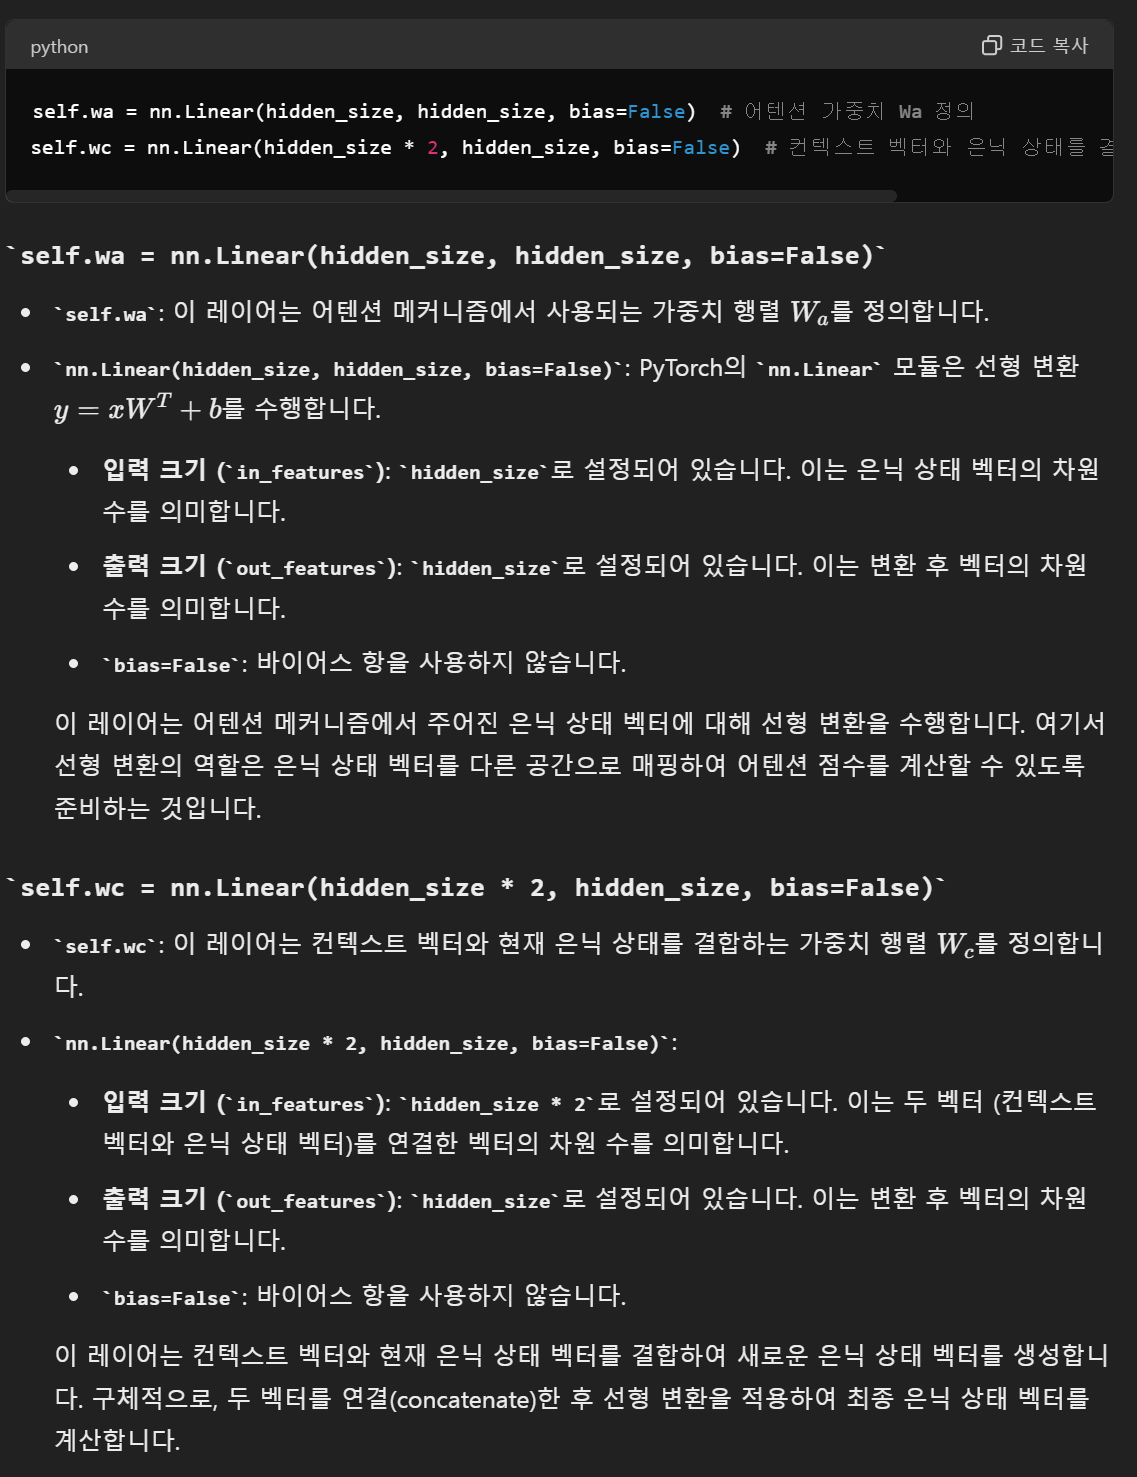
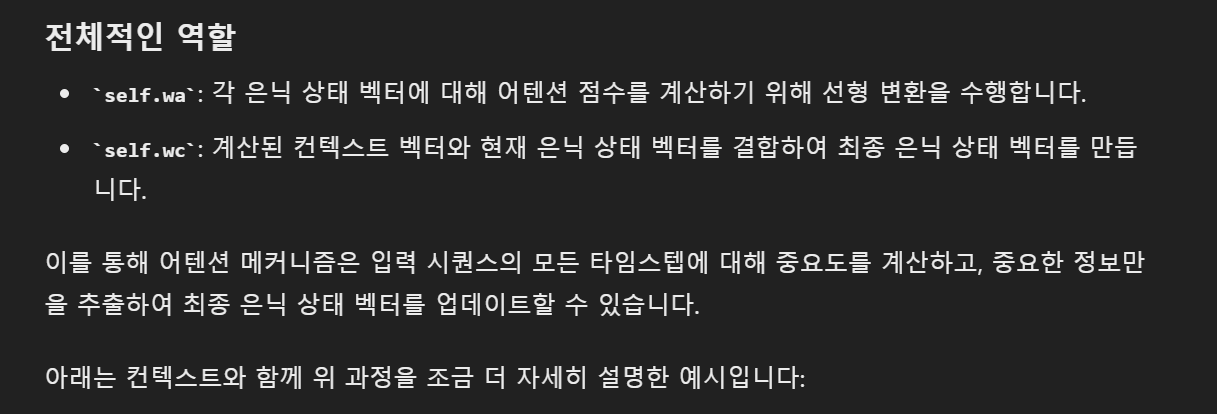
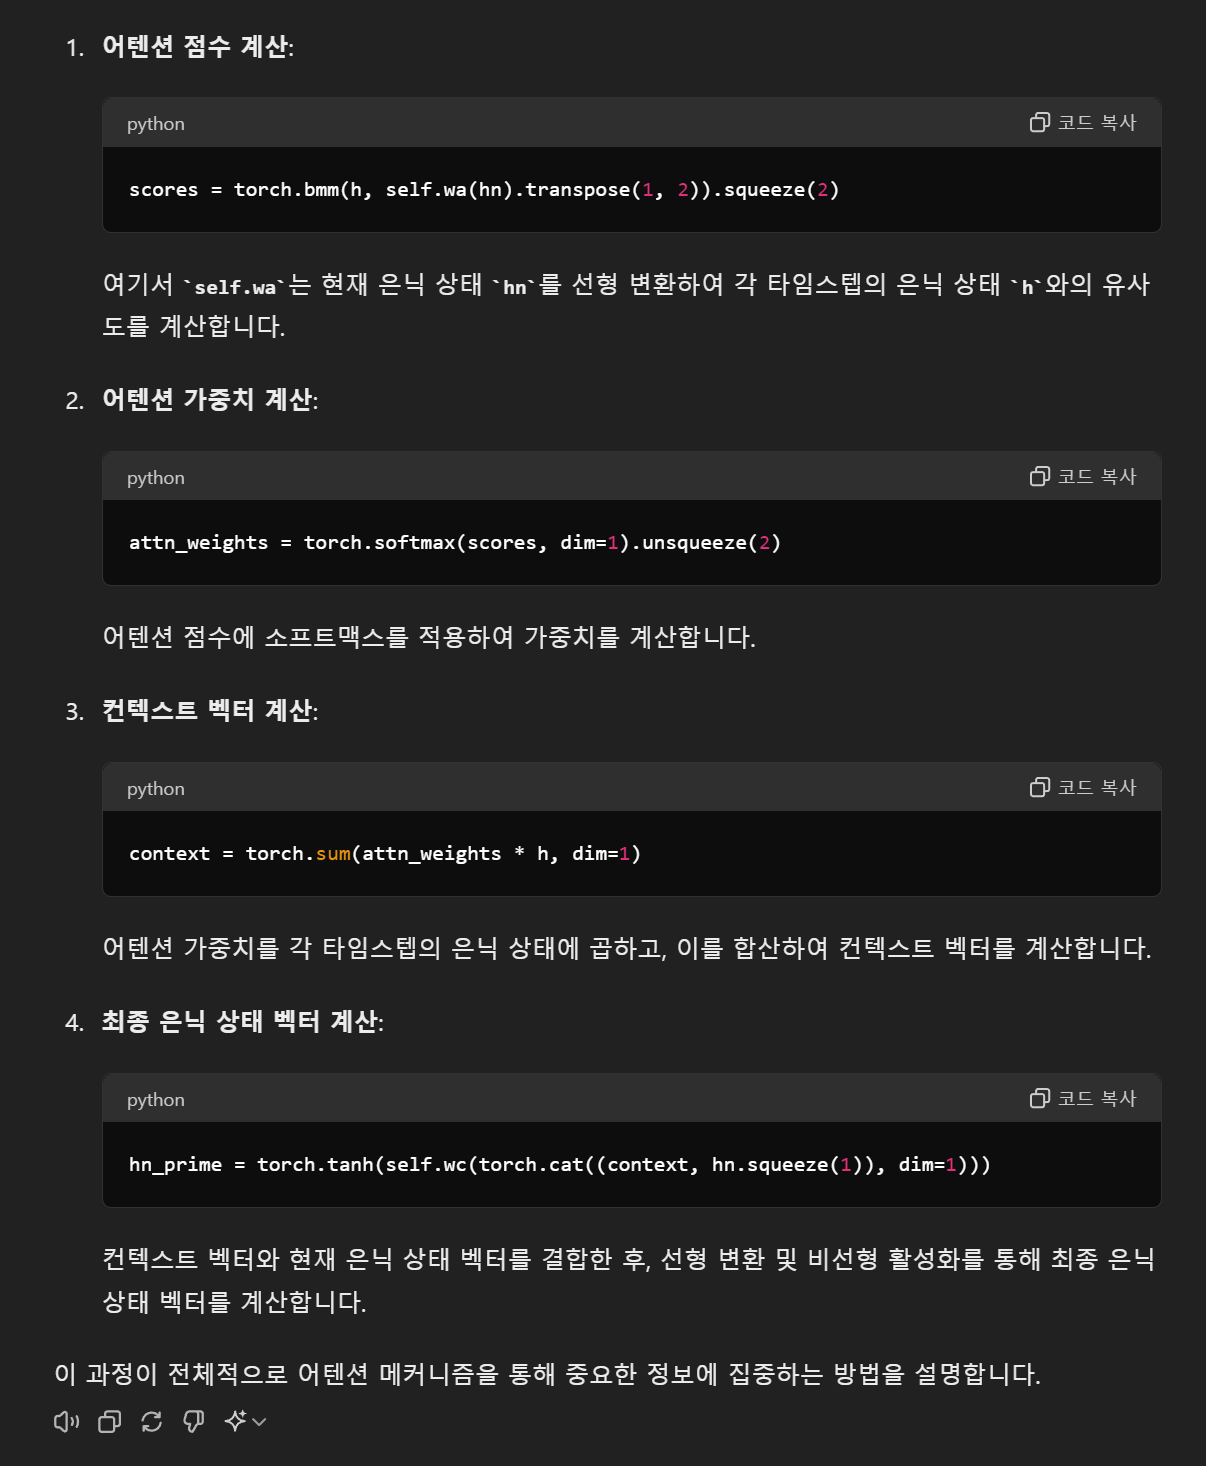